In [5]:
import re
from datetime import datetime
import os

# Define the directory path where the files are stored
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

# Function to parse the filename and extract relevant information
def parse_filename(filename):
    pattern = r'Ramsey_experiment_\[\[([+-]?\d+), ([+-]?\d+), ([+-]?\d+)\]\]_(\d+)_us_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        num1 = int(match.group(1))  # First number
        num2 = int(match.group(2))  # Second number
        num3 = int(match.group(3))  # Third number
        wait_time = int(match.group(4))  # Wait time in microseconds
        date_str = match.group(5) + match.group(6)
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')  # Date and time
        transition_str = f"p{num1}F{num2}n{num3}"  # Create transition string
        return num1, num2, num3, wait_time, date_time, transition_str
    else:
        return None, None, None, None, None, None

# Function to extract raw data filenames from the content of a file
def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filenames from the last line and convert to a list
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')]

    return raw_data_filenames

# Search for files with the same date-time pattern and create a dictionary of wait times
def search_files_by_datetime(directory, target_date_times):
    wait_time_dict = {}
    mf1, F, mf2 = None, None, None
    
    # Loop over all files in the directory
    for filename in os.listdir(directory):
        # Only process files that match the expected pattern
        if filename.startswith('Ramsey_experiment'):
            num1, num2, num3, wait_time, date_time, transition_str = parse_filename(filename)
            # Check if the current file's date-time matches any in the target date-times
            if date_time in target_date_times:
                # Save transition data
                mf1, F, mf2 = num1, num2, num3
                # Parse the raw data filenames for this file
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                
                # Update the dictionary with wait times and file paths
                if wait_time not in wait_time_dict:
                    wait_time_dict[wait_time] = []
                
                # Append file paths to the list of file paths for this wait time
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_PD\\'
                raw_data_filepaths = [Z_drive_raw_data + raw_filename for raw_filename in raw_data_filenames]
                wait_time_dict[wait_time].extend(raw_data_filepaths)
    
    return wait_time_dict, mf1, F, mf2

def extract_datetime_strings(file_path, target_entry):
    with open(file_path, 'r') as file:
        for line in file:

            stripped_line = line.strip()

            end_idx = stripped_line.index(']') + 1
            
            first_entry = eval(stripped_line[:end_idx])
            
            if first_entry == target_entry:
                # Split the line to extract the components
                components = stripped_line.split(', [')
                last_entry = '[' + components[-1] 
                return eval(last_entry)  
    
    return None  

dt_list = extract_datetime_strings('T2_data_qubit.txt',[-1,4,-3])
print(dt_list)
target_date_times = []
for i in dt_list:
    target_date_times.append(datetime.strptime(i, '%Y%m%d_%H%M'))

wait_time_dict, num1, num2, num3 = search_files_by_datetime(directory_path, target_date_times)

# Output the results
print(f"Transition: p{num1}F{num2}n{num3} (mF1: {num1}, F: {num2}, mF2: {num3})")
print("Dictionary of wait times and corresponding raw data file paths:")
for wait_time, file_paths in wait_time_dict.items():
    print(f"Wait time: {wait_time} us")
    for path in file_paths:
        print(f"  {path}")

# if 700 in wait_time_dict:
#     del wait_time_dict[700]


None


TypeError: 'NoneType' object is not iterable

In [1]:
import numpy as np
import json

# Function to calculate the shelving threshold
def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

# Function to process raw data for each wait time
def process_raw_data_files(raw_data_filepaths, Num_points_to_ignore=1):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # print(arrays)
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)
    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        arrays_3d.append(arrays)

    # Convert to numpy array
    bool_array = np.array(arrays_3d) > threshold
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # print(bool_array)
    # Process to identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            if true_indices[0].size > 0:
                first_true_index = true_indices[0]
                # print(first_true_index)
                if first_true_index[0] != 0:
                    result_matrix[matrix_index, row_index, first_true_index[0]] = True
    
    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])
    # print(filtered_data_array)
    # Compute ket data by averaging the filtered data

    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + (np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 /
                            (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))
    
        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - (np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 /
                            (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))
    
        return lower_error, upper_error
    
    ket_data = []
    for i in filtered_data_array:
        ket_data.append(np.mean(i, axis=0)[1])
        
    lower, upper = find_errors(1, np.array(ket_data), len(ket_data))
    return ket_data

# Process all wait times in the dictionary
def process_all_wait_times(wait_time_dict):
    processed_data_dict = {}
    
    for wait_time, raw_data_filepaths in wait_time_dict.items():
        ket_data = process_raw_data_files(raw_data_filepaths)
        processed_data_dict[wait_time] = np.array(ket_data)
    
    return processed_data_dict


processed_data = process_all_wait_times(wait_time_dict)

# Output example
print("Processed Data Dictionary:")
for wait_time, ket_data_list in processed_data.items():
    print(f"Wait Time: {wait_time} us")
    print(f"Ket Data: {ket_data_list}")


NameError: name 'wait_time_dict' is not defined

In [3]:
import numpy as np
import json

# Function to calculate the shelving threshold
def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

# Function to process raw data for each wait time
def process_raw_data_files(raw_data_filepaths):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)
    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        if len(arrays) == 0:
            arrays = list(np.full((100, 4), 40))
        arrays_3d.append(arrays)

    bool_array = np.array(arrays_3d) > threshold
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # Process to identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            if true_indices[0].size > 0:
                first_true_index = true_indices[0]
                if first_true_index[0] != 0:
                    result_matrix[matrix_index, row_index, first_true_index[0]] = True

    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])

    # Compute ket data by averaging the filtered data

    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + (np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 /
                            (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))

        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - (np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 /
                            (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))

        return lower_error, upper_error

    ket_data = []
    exp_num_list = []
    for i in filtered_data_array:
        ket_data.append(np.mean(i, axis=0)[1])
        exp_num_list.append(len(i))
    lower_error, upper_error = find_errors(1, np.array(ket_data), np.array(exp_num_list))
    print(np.array(ket_data), np.array(exp_num_list))
    return ket_data, lower_error, upper_error

# Process all wait times in the dictionary
def process_all_wait_times(wait_time_dict):
    processed_data_dict = {}
    
    for wait_time, raw_data_filepaths in wait_time_dict.items():
        ket_data, lower_error, upper_error = process_raw_data_files(raw_data_filepaths)
        processed_data_dict[wait_time] = {
            'ket_data': np.array(ket_data),
            'lower_error':np.array(ket_data) - np.array(lower_error),
            'upper_error': np.array(upper_error) - np.array(ket_data)
        }
    
    return processed_data_dict

processed_data = process_all_wait_times(wait_time_dict)

# Output example
print("Processed Data Dictionary:")
for wait_time, data in processed_data.items():
    print(f"Wait Time: {wait_time} us")
    print(f"Ket Data: {data['ket_data']}")
    print(f"Lower Error: {data['lower_error']}")
    print(f"Upper Error: {data['upper_error']}")


NameError: name 'wait_time_dict' is not defined

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Sine function for fitting: A * sin(omega * t + phi) + offset
# def sine_function(t, A, phi, offset):
#     return A * np.cos(2 * np.pi / 10 * t + phi) + offset

# # Function to fit ket_data to sine curve, extract amplitude and errors
# def fit_sine_curve(ket_data):
#     # Generate a time array for fitting (assuming equal intervals between points)
#     t = np.arange(len(ket_data))
#     print(ket_data)
#     ket_data = np.array(ket_data, dtype=float)  # Ensures all elements are numeric, raises error if not
    
#     # Remove NaN values from both t and ket_data
#     valid_indices = ~np.isnan(ket_data)  # Find indices where ket_data is not NaN
#     t_valid = t[valid_indices]  # Filter t to keep only valid indices
#     ket_data_valid = ket_data[valid_indices]  # Filter ket_data to remove NaNs
    
#     # Initial guesses for amplitude (A), angular frequency (omega), phase (phi), and offset
#     initial_guess = [1, 0, np.mean(ket_data_valid)]
    
#     try:
#         # Fit the ket_data to the sine function using only valid data
#         params, covariance = curve_fit(sine_function, t_valid, ket_data_valid, p0=initial_guess)
#         # Extract standard deviation errors from the covariance matrix
#         if covariance is not None:
#             errors = np.sqrt(np.diag(covariance))
#             # Handle infinite errors by clamping them to None
#             errors = [error if np.isfinite(error) else None for error in errors]
#         else:
#             errors = [None] * len(params)
        
#         # Return the parameters of the fit and their errors
#         return params, errors
#     except RuntimeError:
#         # If the fit fails, return None
#         return None, None

# # Process the entire processed_data dictionary and fit each ket_data to a sine curve
# def fit_all_wait_times_to_sine(processed_data_dict):
#     fitted_params_dict = {}
#     amplitude_dict = {}
    
#     for wait_time, ket_data in processed_data_dict.items():
#         # Fit the sine curve, skipping NaN values
#         params, errors = fit_sine_curve(ket_data)
#         if params is not None:
#             fitted_params_dict[wait_time] = params
#             amplitude = 2 * np.abs(params[0])  # Extract amplitude (A)
#             amplitude_error = 2 * np.abs(errors[0]) if errors[0] is not None else None  # Extract error of the amplitude
#             amplitude_dict[wait_time] = (amplitude, amplitude_error)  # Store amplitude and error as a tuple
    
#     return fitted_params_dict, amplitude_dict

# # Function to plot the data and fits in a grid with 5 columns
# def plot_sine_fits(processed_data_dict, fitted_params_dict):
#     num_plots = len(processed_data_dict)
#     num_columns = 5
#     num_rows = (num_plots + num_columns - 1) // num_columns  # Ensure enough rows for the data
    
#     fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    
#     # Flatten the axes array for easier indexing
#     axes = axes.flatten()

#     for i, (wait_time, ket_data) in enumerate(processed_data_dict.items()):
#         t = np.arange(len(ket_data))
#         ax = axes[i]
        
#         # Plot the original data
#         ax.plot(t, ket_data, label='Data', marker='o', linestyle='None')
        
#         # If there is a fit, plot the sine curve fit
#         if wait_time in fitted_params_dict:
#             A, phi, offset = fitted_params_dict[wait_time]
#             fit_curve = sine_function(t, A, phi, offset)
#             ax.plot(t, fit_curve, label=f'Fit (A={A:.2f}) \n (phi = {phi}) \n (offset = {offset})', color='red')
        
#         # Set labels and title
#         ax.set_title(f'Wait Time: {wait_time} us')
#         ax.set_xlabel('Time Points')
#         ax.set_ylabel('Amplitude')
#         ax.legend()
    
#     # Hide unused subplots (in case the number of plots isn't a multiple of 5)
#     for i in range(num_plots, len(axes)):
#         fig.delaxes(axes[i])
    
#     plt.tight_layout()
#     plt.show()

# # Example usage
# # Assuming `processed_data` is your dictionary from the previous step
# fitted_params_dict, amplitude_dict = fit_all_wait_times_to_sine(processed_data)

# # Plot the data and fits
# plot_sine_fits(processed_data, fitted_params_dict)

# wait_times = []
# amplitudes = []
# errors = []

# # Print the amplitudes and errors dictionary
# print("Fitted Amplitudes and Errors:")
# for wait_time, (amplitude, error) in amplitude_dict.items():
#     print(f"Wait Time: {wait_time} us, Amplitude: {amplitude} ± {error}")
#     wait_times.append(wait_time)
#     amplitudes.append(amplitude)
#     errors.append(error)
# print(amplitude_dict)

{'ket_data': array([0.4787234 , 0.19565217, 0.03092784, 0.        , 0.1827957 ,
       0.48314607, 0.88421053, 0.96774194, 0.96666667, 0.82105263,
       0.5       ]), 'lower_error': array([0.05102898, 0.03799348, 0.01334473, 0.        , 0.03663238,
       0.05248774, 0.03690355, 0.02386675, 0.02463176, 0.04260822,
       0.05076731]), 'upper_error': array([0.0514769 , 0.0445386 , 0.02291763, 0.01020408, 0.04338141,
       0.05286228, 0.02889917, 0.01391479, 0.01437535, 0.03591962,
       0.05076731])}


TypeError: float() argument must be a string or a real number, not 'dict'

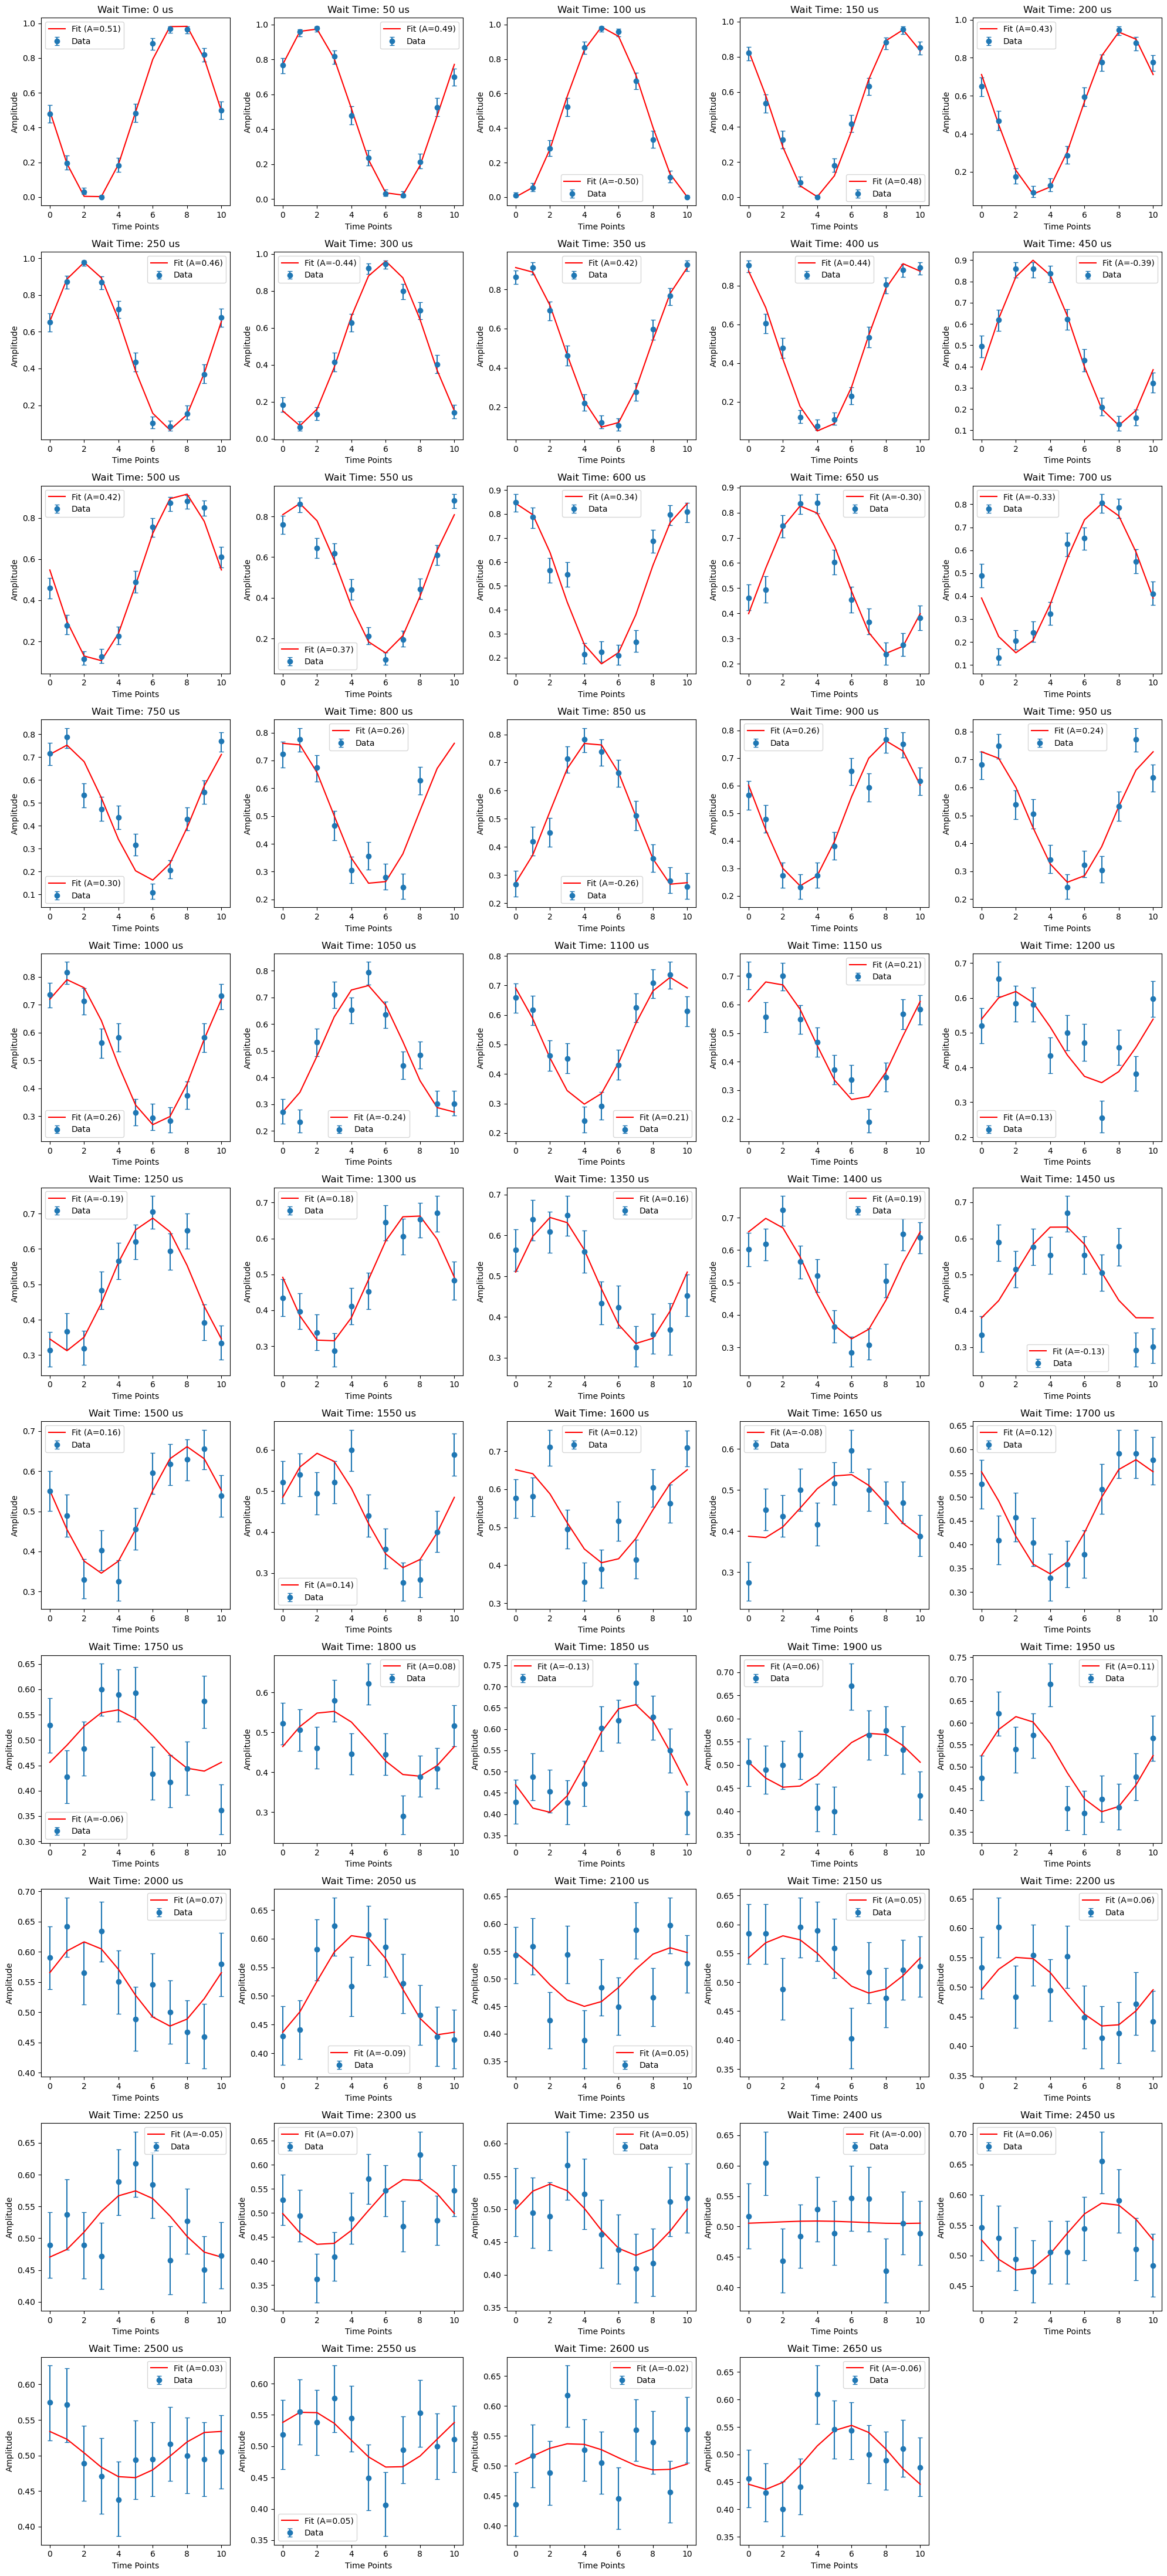

Fitted Amplitudes and Errors:
Wait Time: 0 us, Amplitude: 1.029 ± 0.015
Wait Time: 50 us, Amplitude: 0.988 ± 0.018
Wait Time: 100 us, Amplitude: 0.994 ± 0.013
Wait Time: 150 us, Amplitude: 0.957 ± 0.017
Wait Time: 200 us, Amplitude: 0.865 ± 0.028
Wait Time: 250 us, Amplitude: 0.912 ± 0.024
Wait Time: 300 us, Amplitude: 0.889 ± 0.026
Wait Time: 350 us, Amplitude: 0.834 ± 0.028
Wait Time: 400 us, Amplitude: 0.876 ± 0.027
Wait Time: 450 us, Amplitude: 0.777 ± 0.033
Wait Time: 500 us, Amplitude: 0.83 ± 0.032
Wait Time: 550 us, Amplitude: 0.737 ± 0.032
Wait Time: 600 us, Amplitude: 0.672 ± 0.034
Wait Time: 650 us, Amplitude: 0.593 ± 0.038
Wait Time: 700 us, Amplitude: 0.65 ± 0.038
Wait Time: 750 us, Amplitude: 0.592 ± 0.035
Wait Time: 800 us, Amplitude: 0.524 ± 0.044
Wait Time: 850 us, Amplitude: 0.521 ± 0.038
Wait Time: 900 us, Amplitude: 0.527 ± 0.041
Wait Time: 950 us, Amplitude: 0.473 ± 0.039
Wait Time: 1000 us, Amplitude: 0.526 ± 0.039
Wait Time: 1050 us, Amplitude: 0.483 ± 0.038
Wait 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine function for fitting: A * cos(omega * t + phi) + offset
def sine_function(t, A, phi, offset):
    return A * np.cos(((np.pi*2/10)*t+ phi)) + offset

# Function to fit ket_data to sine curve, extract amplitude and errors
def fit_sine_curve(ket_data, lower_error, upper_error):
    # Generate a time array for fitting (assuming equal intervals between points)
    t = np.arange(len(ket_data))
    
    # Remove NaN values from t, ket_data, and errors
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = ket_data[valid_indices]
    lower_error_valid = lower_error[valid_indices]
    upper_error_valid = upper_error[valid_indices]
    
    # Compute symmetric errors as average of upper and lower errors
    sigma = (upper_error_valid + lower_error_valid) / 2.0
    
    # Avoid zero or negative sigma values
    sigma[sigma <= 0] = np.min(sigma[sigma > 0]) if np.any(sigma > 0) else 1.0
    
    # Initial guesses for amplitude (A), phase (phi), and offset
    initial_guess = [(np.max(ket_data_valid) - np.min(ket_data_valid)), 0, np.mean(ket_data_valid)]
    
    try:
        # Fit the ket_data to the sine function using weights
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True
        )
        
        # Extract standard deviation errors from the covariance matrix
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            # Handle infinite errors by setting them to None
            errors = [error if np.isfinite(error) else None for error in errors]
        else:
            errors = [None] * len(params)
        
        # Return the parameters of the fit and their errors
        return params, errors
    except RuntimeError:
        # If the fit fails, return None
        return None, None

# Process the entire processed_data dictionary and fit each ket_data to a sine curve
def fit_all_wait_times_to_sine(processed_data_dict):
    fitted_params_dict = {}
    amplitude_dict = {}
    
    for wait_time, data in processed_data_dict.items():
        ket_data = data['ket_data']
        lower_error = data['lower_error']
        upper_error = data['upper_error']
        
        # Fit the sine curve using errors
        params, errors = fit_sine_curve(ket_data, lower_error, upper_error)
        if params is not None and errors[0] is not None:
            fitted_params_dict[wait_time] = {'params': params, 'errors': errors}
            amplitude = 2 * np.abs(params[0])  
            amplitude_error = 2 * errors[0] 
            # print(wait_time,amplitude, amplitude_error)
            amplitude_dict[wait_time] = (amplitude, amplitude_error)  # Store amplitude and error as a tuple
    
    return fitted_params_dict, amplitude_dict

# Function to plot the data and fits in a grid with 5 columns
def plot_sine_fits(processed_data_dict, fitted_params_dict):
    num_plots = len(processed_data_dict)
    num_columns = 5
    num_rows = (num_plots + num_columns - 1) // num_columns  # Ensure enough rows for the data
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (wait_time, data) in enumerate(processed_data_dict.items()):
        ket_data = data['ket_data']
        lower_error = data['lower_error']
        upper_error = data['upper_error']
        t = np.arange(len(ket_data))
        ax = axes[i]
        
        # Plot the original data with error bars
        ax.errorbar(t, ket_data, yerr=[abs(lower_error), abs(upper_error)], fmt='o', label='Data', capsize=3)
        
        # If there is a fit, plot the sine curve fit
        if wait_time in fitted_params_dict:
            params = fitted_params_dict[wait_time]['params']
            A, phi, offset = params
            fit_curve = sine_function(t, A, phi, offset)
            ax.plot(t, fit_curve, label=f'Fit (A={A:.2f})', color='red')
        
        # Set labels and title
        ax.set_title(f'Wait Time: {wait_time} us')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    # Hide unused subplots (in case the number of plots isn't a multiple of 5)
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `processed_data` is your dictionary from the previous step
# processed_data = process_all_wait_times(wait_time_dict)

fitted_params_dict, amplitude_dict = fit_all_wait_times_to_sine(processed_data)

# Plot the data and fits
plot_sine_fits(processed_data, fitted_params_dict)

wait_times = []
amplitudes = []
errors = []

# Print the amplitudes and errors dictionary
big_errors_waitTimes = []
print("Fitted Amplitudes and Errors:")
for wait_time, (amplitude, error) in amplitude_dict.items():
    # if error <0.1:
    print(f"Wait Time: {wait_time} us, Amplitude: {np.round(amplitude,3)} ± {np.round(error,3)}")
    wait_times.append(wait_time)
    if amplitude > 1:
        amplitudes.append(1)
    else:
        amplitudes.append(amplitude)
    errors.append(error)
#     else: 
#         big_errors_waitTimes.append(wait_time)
# for i in big_errors_waitTimes:
#     del amplitude_dict[i]
#     print('removed wait times: ',i)

In [13]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Combined decay model: A * exp(-(t/T2_G)^2) * exp(-t/T2_L)
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

# Fit function with WLS (weighted least squares)
def fit_decay_to_combined_model(wait_times, amplitudes, errors):
    # Ensure initial guesses are scalar values
    print(len(wait_times))
    initial_guess = [
        float(np.max(amplitudes)),       # Starting guess for amplitude
        float(np.mean(wait_times)),      # Starting guess for Gaussian decay
        float(np.mean(wait_times))       # Starting guess for Lorentzian decay
    ]

    try:
        # Use WLS by passing `sigma=errors`
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,  # Apply the weights using the uncertainties
            absolute_sigma=True,  # Ensures the errors are treated as absolute uncertainties
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
    except RuntimeError:
        return None, None, None, None

# Fit the amplitude data with WLS
def fit_amplitude_decay(amplitude_data):
    # Extract wait_times, amplitudes, and errors as arrays
    wait_times = np.array(list(amplitude_data.keys()))
    amplitudes = np.array(list(amplitude_data.values()))[:,0]
    errors = np.array(list(amplitude_data.values()))[:,1]

    # Check shapes
    print('wait_times shape:', wait_times.shape)
    print('amplitudes shape:', amplitudes.shape)
    print('errors shape:', errors.shape)

    # Flatten amplitudes and errors if they are 2D arrays
    if amplitudes.ndim == 2:
        # Flatten amplitudes and errors
        amplitudes_flat = amplitudes.flatten()
        errors_flat = errors.flatten()
        # Repeat wait_times accordingly
        wait_times_flat = np.repeat(wait_times, amplitudes.shape[1])
    elif amplitudes.ndim == 1:
        # Data is already flat
        amplitudes_flat = amplitudes
        errors_flat = errors
        wait_times_flat = wait_times
    else:
        raise ValueError('Amplitudes array has unexpected number of dimensions')

    # Ensure all arrays have the same length
    if len(wait_times_flat) != len(amplitudes_flat) or len(amplitudes_flat) != len(errors_flat):
        raise ValueError("Mismatch in array sizes: wait_times, amplitudes, and errors must have the same length.")

    A, T2_G, T2_L, pcov = fit_decay_to_combined_model(wait_times_flat, amplitudes_flat, errors_flat)

    return A, abs(T2_G), T2_L, pcov

# Calculate the coherence time from T2_G and T2_L
def calculate_coherence_time(T2_G, T2_L):
    # Define the decay function equation to solve for coherence time at 1/e drop
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e

    # Use fsolve to find the time where decay equals 1/e
    
    t_coherence = fsolve(decay_eq, min(T2_G,abs(T2_L)))  # Initial guess is T2_G
    return t_coherence[0]

# Compute partial derivatives for error propagation
def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    # Derivatives of the decay equation
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2

    # Compute ∂t/∂T2_G and ∂t/∂T2_L
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt

    return dt_dT2_G, dt_dT2_L


A, T2_G, T2_L, pcov = fit_amplitude_decay(amplitude_dict)


if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    # Extract standard deviations from the covariance matrix
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]

    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")

    # Calculate effective coherence time
    T2_eff = calculate_coherence_time(T2_G, T2_L)

    # Compute partial derivatives for error propagation
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)

    # Calculate the variance of T2_eff
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)

    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
else:
    print("Fit failed or not enough data.")


wait_times shape: (54,)
amplitudes shape: (54,)
errors shape: (54,)
54
Fitted Coherence Times:
A (Amplitude) = 1.0362411471551563 ± 0.009267867862767044
T2_G (Gaussian) = 2054.4241218909024 ± 137.9440478815355
T2_L (Lorentzian) = 1916.8500604713997 ± 163.7493594828443
Effective T2 Time: 1229.8832875263467 ± 21.140442911554537


In [15]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Combined decay model: A * exp(-(t/T2_G)^2) * exp(-t/T2_L)
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

# Fit function with WLS (weighted least squares)
def fit_decay_to_combined_model(wait_times, amplitudes, errors):
    # Ensure initial guesses are scalar values
    print(len(wait_times))
    initial_guess = [
        float(np.max(amplitudes)),       # Starting guess for amplitude
        float(np.mean(wait_times)),      # Starting guess for Gaussian decay
        float(np.mean(wait_times))       # Starting guess for Lorentzian decay
    ]

    try:
        # Set bounds: Amplitude (A) between 0 and 1, and no bounds for T2_G and T2_L
        bounds = ([0, -np.inf, -np.inf], [1, np.inf, np.inf])
        
        # Use WLS by passing `sigma=errors`
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,  # Apply the weights using the uncertainties
            # bounds=bounds,  # Set bounds for parameters
            absolute_sigma=True,  # Ensures the errors are treated as absolute uncertainties
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
    except RuntimeError:
        return None, None, None, None

# Fit the amplitude data with WLS
def fit_amplitude_decay(amplitude_data):
    # Extract wait_times, amplitudes, and errors as arrays
    wait_times = np.array(list(amplitude_data.keys()))
    amplitudes = np.array(list(amplitude_data.values()))[:,0]
    errors = np.array(list(amplitude_data.values()))[:,1]
    print(wait_times,amplitudes,errors)
    # Check shapes
    print('wait_times shape:', wait_times.shape)
    print('amplitudes shape:', amplitudes.shape)
    print('errors shape:', errors.shape)

    # Flatten amplitudes and errors if they are 2D arrays
    if amplitudes.ndim == 2:
        # Flatten amplitudes and errors
        amplitudes_flat = amplitudes.flatten()
        errors_flat = errors.flatten()
        # Repeat wait_times accordingly
        wait_times_flat = np.repeat(wait_times, amplitudes.shape[1])
    elif amplitudes.ndim == 1:
        # Data is already flat
        amplitudes_flat = amplitudes
        errors_flat = errors
        wait_times_flat = wait_times
    else:
        raise ValueError('Amplitudes array has unexpected number of dimensions')

    # Ensure all arrays have the same length
    if len(wait_times_flat) != len(amplitudes_flat) or len(amplitudes_flat) != len(errors_flat):
        raise ValueError("Mismatch in array sizes: wait_times, amplitudes, and errors must have the same length.")

    A, T2_G, T2_L, pcov = fit_decay_to_combined_model(wait_times_flat, amplitudes_flat, errors_flat)

    return A, abs(T2_G), T2_L, pcov

# Calculate the coherence time from T2_G and T2_L
def calculate_coherence_time(T2_G, T2_L):
    # Define the decay function equation to solve for coherence time at 1/e drop
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e

    # Use fsolve to find the time where decay equals 1/e
    
    t_coherence = fsolve(decay_eq, min(T2_G,abs(T2_L)))  # Initial guess is T2_G
    return t_coherence[0]

# Compute partial derivatives for error propagation
def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    # Derivatives of the decay equation
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2

    # Compute ∂t/∂T2_G and ∂t/∂T2_L
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt

    return dt_dT2_G, dt_dT2_L


A, T2_G, T2_L, pcov = fit_amplitude_decay(amplitude_dict)


if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    # Extract standard deviations from the covariance matrix
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]

    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")

    # Calculate effective coherence time
    T2_eff = calculate_coherence_time(T2_G, T2_L)

    # Compute partial derivatives for error propagation
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)

    # Calculate the variance of T2_eff
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)

    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
else:
    print("Fit failed or not enough data.")


[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350
 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050
 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650] [1.0285683  0.98779042 0.99441927 0.95687318 0.86511215 0.9124005
 0.88936983 0.83437956 0.87627605 0.77658887 0.83016608 0.73653101
 0.67232636 0.5928677  0.65046491 0.59233023 0.5237622  0.52078013
 0.52743535 0.47313472 0.52567907 0.48347047 0.42981411 0.42318551
 0.26313356 0.37449083 0.36319452 0.31381303 0.37219013 0.2634985
 0.31558705 0.27951466 0.24869319 0.15805363 0.23983775 0.12231417
 0.16672542 0.25759462 0.11974268 0.21972601 0.1394796  0.17795074
 0.10679636 0.09936882 0.12019108 0.1044466  0.13946144 0.10860312
 0.00397685 0.11273973 0.06699043 0.09132917 0.04499268 0.11673411] [0.01453485 0.01759655 0.01297113 0.01672467 0.02825459 0.02423363
 0.02574919 0.02787373 0.02724926 0.03338873 0.03165627 

In [17]:
def write_or_update_t2_eff(filename, num1, num2, num3, T2_eff,sigma_T2_eff,T2_G,T2_L,dt_list):
    data_exists = False
    lines = []
    
    # Check if file exists
    if os.path.exists(filename):
        # Read the file line by line
        with open(filename, 'r') as file:
            lines = file.readlines()
        
        # Check if the entry exists and update it
        for i, line in enumerate(lines):
            if line.startswith(f"[{num1},{num2},{num3}]"):
                lines[i] = f"[{num1},{num2},{num3}], {T2_eff}, {sigma_T2_eff}, {T2_G}, {T2_L}, {dt_list}\n"
                data_exists = True
                break
    
    # If entry does not exist, append the new entry
    if not data_exists:
        lines.append(f"[{num1},{num2},{num3}], {T2_eff}, {sigma_T2_eff}, {T2_G}, {T2_L}, {dt_list}\n")
    
    # Write the updated content back to the file
    with open(filename, 'w') as file:
        file.writelines(lines)
filename = 'T2_data_qubit.txt'
write_or_update_t2_eff(filename, num1, num2, num3, T2_eff,sigma_T2_eff,T2_G,T2_L,dt_list)

In [101]:
%matplotlib widget

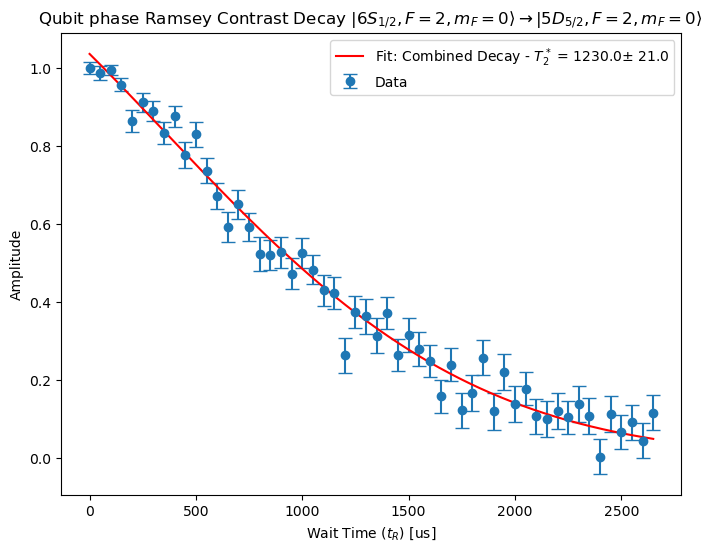

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Combined Gaussian and Lorentzian decay function
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G) ** 2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * (gaussian_decay * lorentzian_decay)

# Plot the amplitude data, fit, and error bars
def plot_fit(wait_times, amplitudes, errors, T2_G,sigma_T2_eff, T2_L, A, T2_eff,num1,num2,num3):
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)

    plt.figure(figsize=(8, 6))
    # Plot the amplitude data with error bars
    plt.errorbar(np.array(wait_times), amplitudes, yerr=errors, fmt='o', label='Data', capsize=5)
    
    # Plot the fit curve
    plt.plot(t_fit, amplitude_fit, color='red', label=rf'Fit: Combined Decay - $T_2^*$ = {np.round(T2_eff)}± {np.round(sigma_T2_eff)}')
    
    plt.xlabel('Wait Time ($t_R$) [us]')
    plt.ylabel('Amplitude')
    plt.title(rf'Qubit phase Ramsey Contrast Decay $|6S_{{1/2}},F=2,m_F = {num1}\rangle \rightarrow |5D_{{5/2}},F={num2},m_F = {num3}\rangle$ ')
    plt.legend()
    
    # Save the figure
    plt.savefig(f'Ramsey_contrast_decay_{num1}_{num2}_{num3}.png', dpi=300)
    plt.show()

# Example usage assuming the fit was successful
# Replace the following values with actual fit results and data:

plot_fit(wait_times, amplitudes, errors, T2_G,sigma_T2_eff, T2_L, A, T2_eff,num1,num2,num3)


In [1855]:
def Fit_contrast_decay(triplet):
    dt_list = extract_datetime_strings('T2_data_qubit.txt',triplet)
    target_date_times = []
    for i in dt_list:
        target_date_times.append(datetime.strptime(i, '%Y%m%d_%H%M'))
    
    wait_time_dict, num1, num2, num3 = search_files_by_datetime(directory_path, target_date_times)
    processed_data = process_all_wait_times(wait_time_dict)
    fitted_params_dict, amplitude_dict = fit_all_wait_times_to_sine(processed_data)
    
    plot_sine_fits(processed_data, fitted_params_dict)
    
    wait_times = []
    amplitudes = []
    errors = []
    
    print("Fitted Amplitudes and Errors:")
    for wait_time, (amplitude, error) in amplitude_dict.items():
        print(f"Wait Time: {wait_time} us, Amplitude: {amplitude} ± {error}")
        wait_times.append(wait_time)
        amplitudes.append(amplitude)
        errors.append(error)
    
    A, T2_G, T2_L, pcov = fit_amplitude_decay(amplitude_dict)
    
    
    if all(param is not None for param in [A, T2_G, T2_L, pcov]):
        # Extract standard deviations from the covariance matrix
        sigma_A = np.sqrt(pcov[0, 0])
        sigma_T2_G = np.sqrt(pcov[1, 1])
        sigma_T2_L = np.sqrt(pcov[2, 2])
        cov_T2_G_T2_L = pcov[1, 2]
    
        print(f"Fitted Coherence Times:")
        print(f"A (Amplitude) = {A} ± {sigma_A}")
        print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
        print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")
    
        # Calculate effective coherence time
        T2_eff = calculate_coherence_time(T2_G, T2_L)
    
        # Compute partial derivatives for error propagation
        dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)
    
        # Calculate the variance of T2_eff
        sigma_T2_eff_squared = (
            (dt_dT2_G**2) * sigma_T2_G**2 +
            (dt_dT2_L**2) * sigma_T2_L**2 +
            2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
        )
        sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)
    
        print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
    else:
        print("Fit failed or not enough data.")
    
    filename = 'T2_data_qubit.txt'
    write_or_update_t2_eff(filename, num1, num2, num3, T2_eff,sigma_T2_eff,T2_G,T2_L,dt_list)
    plot_fit(wait_times, amplitudes, errors, T2_G, sigma_T2_eff,T2_L, A, T2_eff,num1,num2,num3)

In [1857]:
import re

def read_t2_data(filename):
    triplets = []
    T2_eff_list = []
    sigma_T2_eff_list = []
    T2_G_list = []
    T2_L_list = []
    
    # Updated pattern to handle negative numbers
    pattern = r'\[\s*(-?\d+),\s*(-?\d+),\s*(-?\d+)\s*\],\s*([\d.]+),\s*([\d.]+),\s*([\d.]+),\s*([\d.]+)'
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.match(pattern, line.strip())
            if match:
                # Extract the triplet (num1, num2, num3)
                num1 = int(match.group(1))
                num2 = int(match.group(2))
                num3 = int(match.group(3))
                triplets.append([num1, num2, num3])
                print(triplets)
                # Extract the T2_eff, T2_G, and T2_L values
                T2_eff = float(match.group(4))
                sigma_T2_eff = float(match.group(5))
                T2_G = float(match.group(6))
                T2_L = float(match.group(7))
                
                T2_eff_list.append(T2_eff)
                sigma_T2_eff_list.append(sigma_T2_eff)
                T2_G_list.append(T2_G)
                T2_L_list.append(T2_L)
        
    return triplets, T2_eff_list, sigma_T2_eff_list, T2_G_list, T2_L_list


# Example usage
filename = 'T2_data_qubit.txt'  # Replace with your file path

# Read the data from the file
triplets, T2_eff_list,sigma_T2_eff_list, T2_G_list, T2_L_list = read_t2_data(filename)

print(triplets)

[[0, 3, 2]]
[[0, 3, 2], [0, 2, 2]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0], [2, 4, 1]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0], [2, 4, 1], [1, 4, 0]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0], [2, 4, 1], [1, 4, 0], [0, 4, -1]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0], [2, 4, 1], [1, 4, 0], [0, 4, -1], [2, 4, 4]]
[[0, 3, 2], [0, 2, 2], [0, 2, 0], [2, 4, 2], [0, 4, 0], [2, 4, 1], [1, 4, 0], [0, 4, -1], [2, 4, 4]]


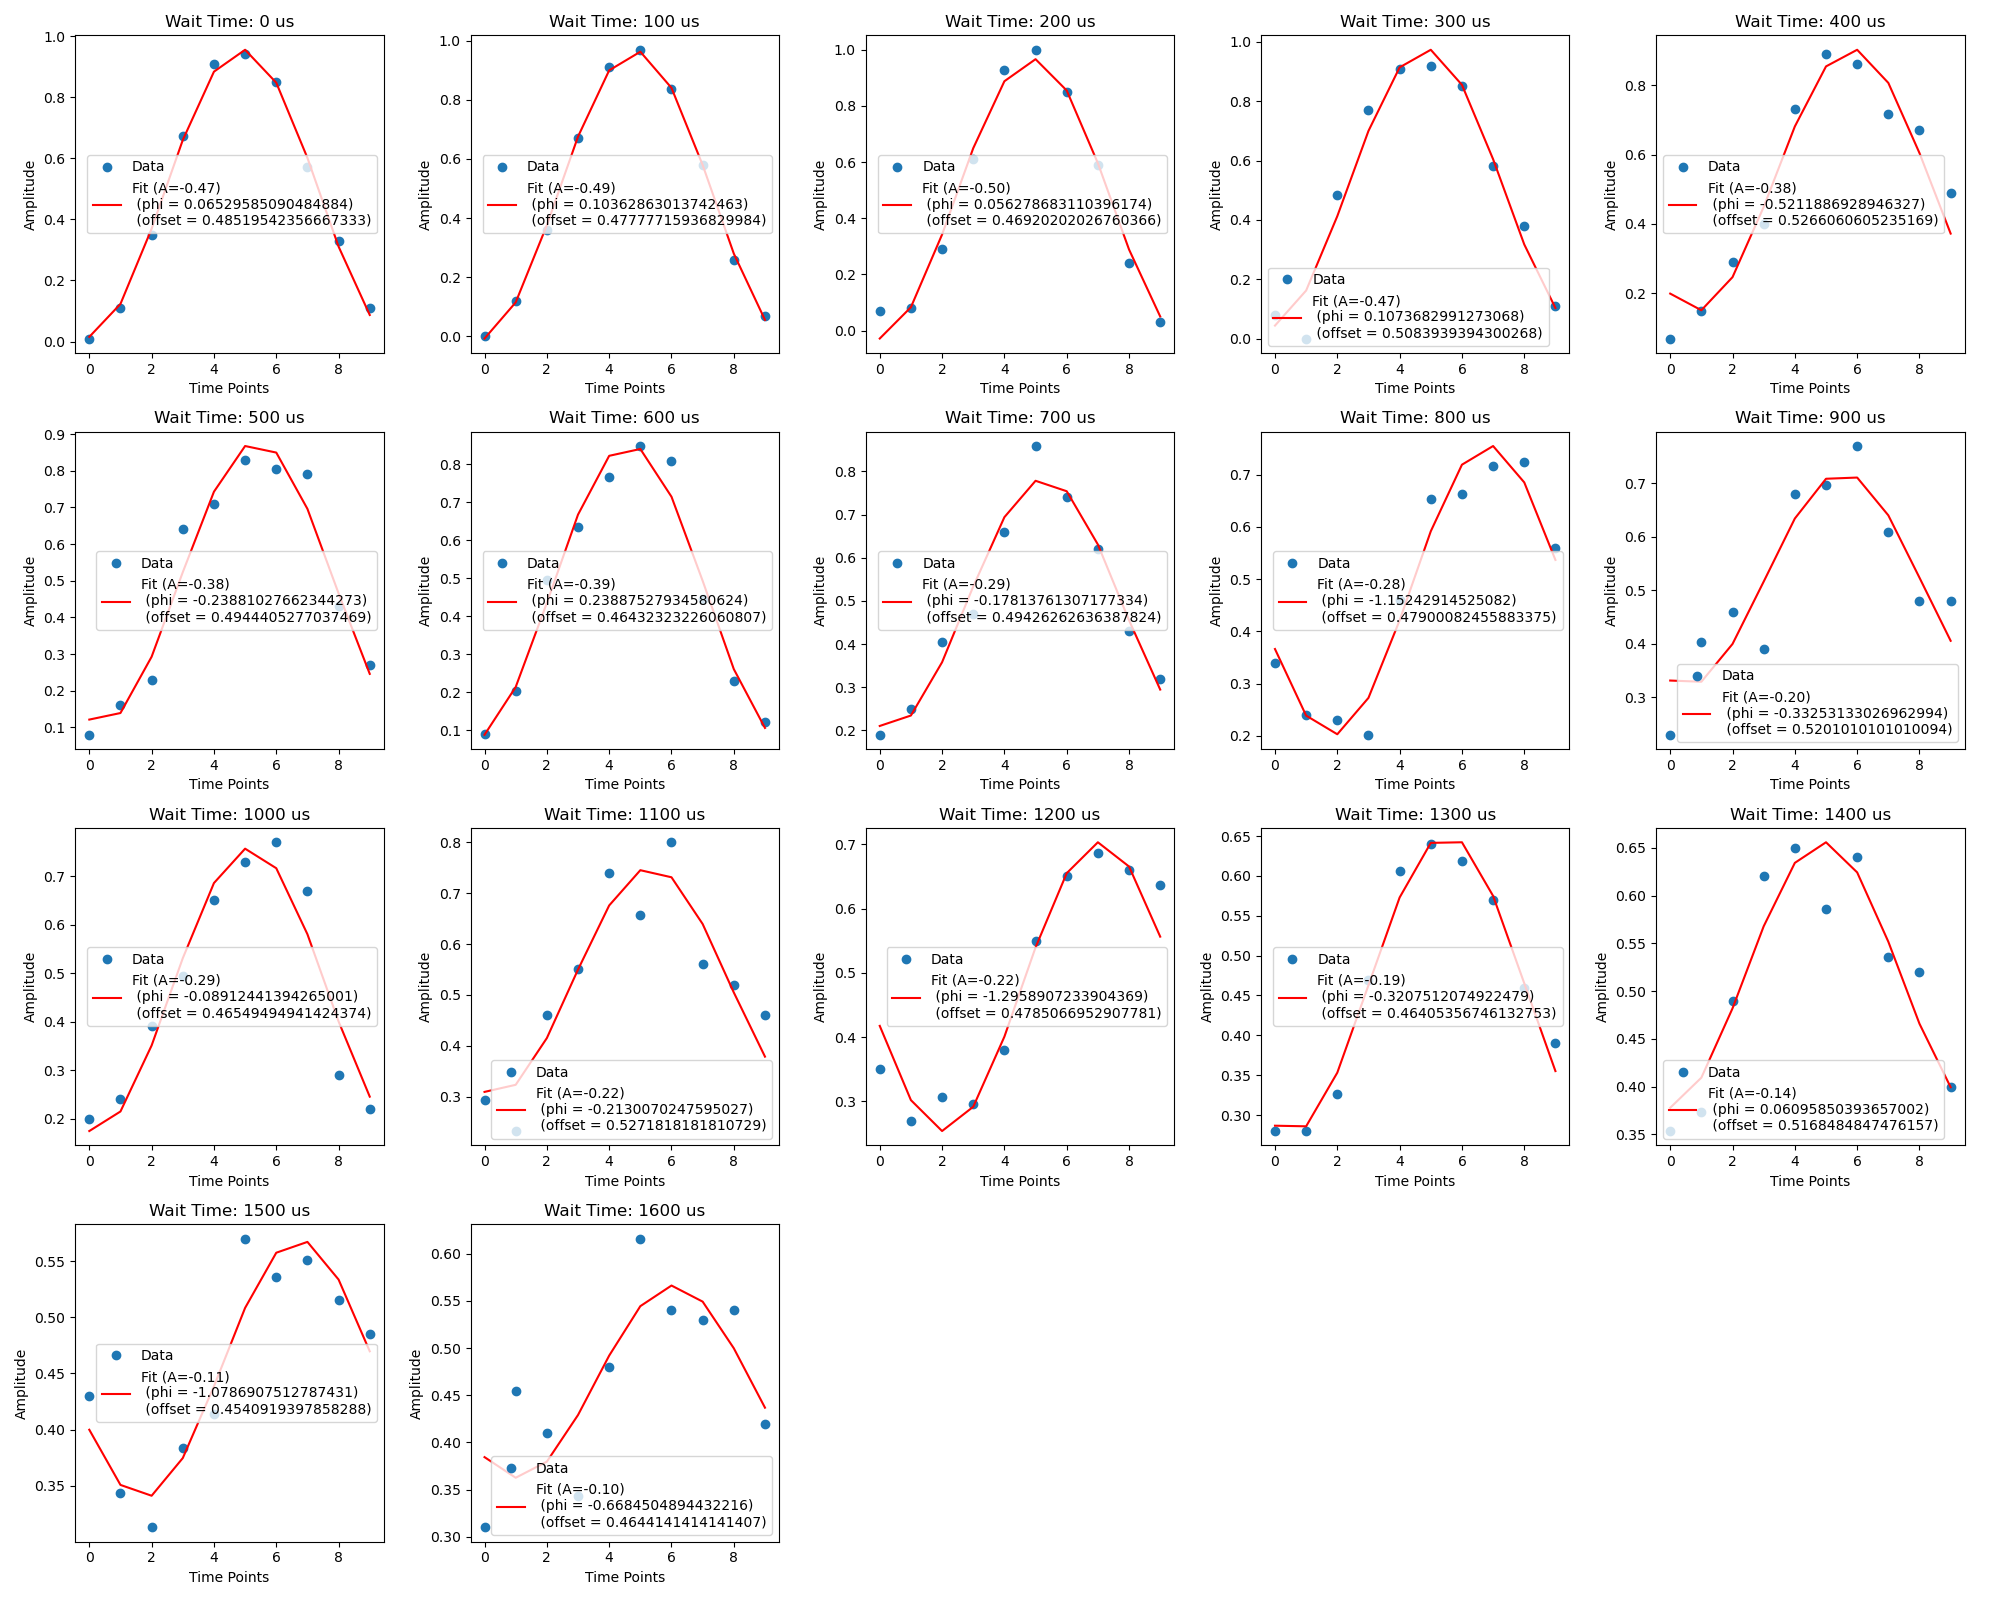

Fitted Amplitudes and Errors:
Wait Time: 0 us, Amplitude: 0.9415191956251501 ± 0.020194961893864993
Wait Time: 100 us, Amplitude: 0.9751623863182001 ± 0.011277490245121608
Wait Time: 200 us, Amplitude: 0.9961905733902651 ± 0.047054016958268455
Wait Time: 300 us, Amplitude: 0.9350092484944491 ± 0.07185500331105381
Wait Time: 400 us, Amplitude: 0.7545992037905037 ± 0.0774923781410245
Wait Time: 500 us, Amplitude: 0.7677558151192238 ± 0.06311916320502832
Wait Time: 600 us, Amplitude: 0.7747041142553579 ± 0.047867809591687946
Wait Time: 700 us, Amplitude: 0.5767938582473189 ± 0.042760386436495414
Wait Time: 800 us, Amplitude: 0.554982738390122 ± 0.04575403690285583
Wait Time: 900 us, Amplitude: 0.39922244274723623 ± 0.07524558063845069
Wait Time: 1000 us, Amplitude: 0.5849271285285627 ± 0.058402386173095656
Wait Time: 1100 us, Amplitude: 0.44591523284078566 ± 0.06795202189527305
Wait Time: 1200 us, Amplitude: 0.44977776987002754 ± 0.0422132728618678
Wait Time: 1300 us, Amplitude: 0.3737968

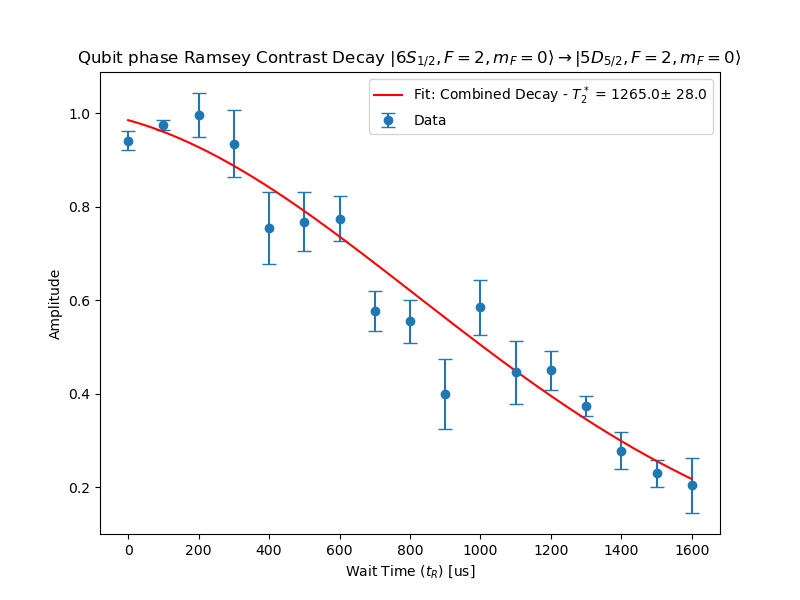

In [1867]:
Fit_contrast_decay([0,2,0])